### Quantum Chemistry - Ground State and Excited Energy Solver
We aim to minimize the expectation value of the observable

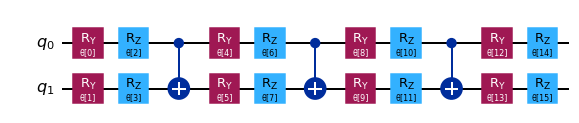

In [1]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

chem_ansatz = EfficientSU2(H2_op.num_qubits)

chem_ansatz.decompose().draw("mpl")

In [2]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    return cost

In [3]:
import numpy as np

x0 = np.ones(chem_ansatz.num_parameters)

In [4]:
from qiskit.primitives import StatevectorEstimator as Estimator, StatevectorSampler as Sampler

estimator = Estimator()
sampler = Sampler()

In [5]:
from scipy.optimize import minimize
import time

start_time = time.time()

result = minimize(cost_func_vqe, x0, args=(chem_ansatz, H2_op, estimator), method="COBYLA")

end_time = time.time()
execution_time = end_time - start_time

result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.8572750227204782
       x: [ 8.421e-01  1.430e+00 ...  9.932e-01  1.704e+00]
    nfev: 257
   maxcv: 0.0

The min value - 1.857... is the ground state energy of the h2 molecule in hartress

Now, let us check for the ground state and the first excited state

In [7]:
k = 2
betas = [33, 33]
x0=[ 1.164e+00, -2.438e-01,  9.358e-04,  6.745e-02,  1.990e+00,   9.810e-02,  6.154e-01,  5.454e-01]

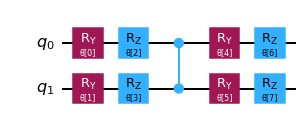

In [12]:
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(2, rotation_blocks=["ry", "rz"], entanglement_blocks="cz", reps=1)

ansatz.decompose().draw('mpl')

In [13]:
import numpy as np
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

def calculate_overlaps(ansatz, prev_circuits, parameters, sampler, realbackend,backend):

    def create_fidelity_circuit(circuit_1, circuit_2):
        if len(circuit_1.clbits) > 0:
            circuit_1.remove_final_measurements()
        if len(circuit_2.clbits) > 0:
            circuit_2.remove_final_measurements()

        circuit = circuit_1.compose(circuit_2.inverse())
        circuit.measure_all()
        return circuit
    overlaps = []

    for prev_circuit in prev_circuits:
        fidelity_circuit = create_fidelity_circuit(ansatz, prev_circuit)
        if realbackend == 1:
            pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
            fidelity_circuit = pm.run(fidelity_circuit)
        sampler_job = sampler.run([(fidelity_circuit, parameters)])
        meas_data = sampler_job.result()[0].data.meas
        
        counts_0 = meas_data.get_int_counts().get(0, 0)
        shots = meas_data.num_shots
        overlap = counts_0/shots
        overlaps.append(overlap)
    
    return np.array(overlaps)

In [14]:
def cost_func_vqd(parameters, ansatz, prev_states, step, betas, estimator, sampler, hamiltonian, realbackend, backend):
    
    estimator_job = estimator.run([(ansatz, hamiltonian, [parameters])])

    total_cost = 0

    if step > 1:
        overlaps = calculate_overlaps(ansatz, prev_states, parameters, sampler, realbackend, backend)
        total_cost = np.sum([np.real(betas[state] * overlap) for state, overlap in enumerate(overlaps)])

    estimator_result = estimator_job.result()[0]

    value = estimator_result.data.evs[0] + total_cost

    return value

In [15]:
from scipy.optimize import minimize

prev_states = []
prev_opt_parameters = []
eigenvalues = []

realbackend = 0

for step in range(1, k + 1):
    
    if step > 1:
        prev_states.append(ansatz.assign_parameters(prev_opt_parameters))
    
    result = minimize(cost_func_vqd, x0, args=(ansatz, prev_states, step, betas, estimator, sampler, H2_op, realbackend, None), method="COBYLA", options = {'tol': 0.001, 'maxiter': 2000})
    print(result)

    prev_opt_parameters = result.x
    eigenvalues.append(result.fun)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.857267296141082
       x: [ 1.164e+00 -2.432e-01  1.330e-03  6.455e-02  1.990e+00
            9.860e-02  6.133e-01  5.457e-01]
    nfev: 57
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.0337904157439637
       x: [ 3.222e+00  1.672e+00  2.095e+00 -3.225e-01  3.127e+00
            1.799e+00  4.001e-01  5.180e-01]
    nfev: 136
   maxcv: 0.0


In [16]:
eigenvalues

[-1.857267296141082, -1.0337904157439637]